# I. Introduction

### Final Project

- Study Group 4 Hacktiv8, Batch 011 Full Time Data Science
- Our team :
  - Megatheo J. Rumahorbo
  - Aditya Vianseto
  - Hafiz Febry
  - Nabila Edelliana K

## Objectives
This Project aims to create a user-friendly chatbot (GitCoff" for e-commerce "GitCoffee" to help communicating with customers in the more effective way for non-technical question with the concept of machine learning and NLP.

## Dataset
We build our own dataset in order to have a relevan dataset and in to complete the aims of the objectives.
1. Intents : contains 3 informations, dataset for the chatbot
    - tag : defines the class of the question/input and the answer/output.
    - pattern : the data that represent the input for GitCoff from user/customer and will be trained later to the model.
    - responses : defines the responses that will be selected randomly as the output for the input.
2. data_kopi.csv : contains 5 informations, dataset for recommeder system.

# II. Import Library

In [149]:
# Import library that will be used in this project

# Library for Visualization
import matplotlib.pyplot as plt

# Library for preprocessing
import string
import re
import numpy as np
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Library for modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from util import JSONParser
from sklearn.model_selection import train_test_split

# Library for model evaluation
from sklearn import metrics

# Data Loading

In [150]:
# Load data from folders
path = "dataset/intents.json"

# Defining JSONParser
jp = JSONParser()

# Parsing data intents
jp.parse(path)

# Building dataframe and save it to variable df
df = jp.get_dataframe()

In [151]:
df

,text_input,intents
0,Hai,menyapa
1,Halo,menyapa
2,Hei,menyapa
3,Oi,menyapa
4,Woy,menyapa
...,...,...
1028,Kopi yang paling mahal dijual disini ada gak sih?,kopi_mahal
1029,jenis kopi yang harganya paling mahal ada gak?...,kopi_mahal
1030,Punya kopi yang harganya paling mahal kan,kopi_mahal
1031,Punya kopi termahal kan? kasih tau aku bisa?,kopi_mahal


There are 1003 data with 2 columns. Note that will be using `intents` as our target when modelling the data.

In [152]:
df.intents.nunique()

33

We have 33 tag

In [153]:
df.intents.value_counts()

menyapa                 57
menutup                 52
e-wallet                42
komplain                39
pahit                   36
manis                   35
pengiriman              35
latte                   34
blackivory              33
pembayaran              33
luwak                   32
robusta                 32
metode bayar            32
produk                  31
kritik saran            31
transfer                31
namatoko                31
macchiato               30
kopikreasi              30
tinggicafein            30
americano               30
espresso                30
moccachino              29
beda arabica robusta    28
kopi_mahal              27
pemesanan               25
pembatalan              25
arabica                 25
nama                    23
cappucino               23
status_pesanan          21
estimasi                21
tugas                   20
Name: intents, dtype: int64

tag terbanyak adalah "menutup" yaitu terdapat 52 text dengan tag "menutup"
paling sedikit adalah "tugas" yaitu terdapat 20 text dengan tag "tugas"

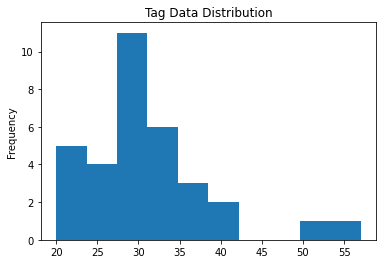

Skewness :  1.5243594136950154


In [154]:
df.intents.value_counts().plot(kind='hist')
plt.title("Tag Data Distribution")
plt.show()
print("Skewness : ",df.intents.value_counts().skew())

Data is right skew

# III. Data Preprocessing

### 3.1. Data Cleaning

In [155]:
# Look into sample chat
sample_chat = df.text_input[200]
sample_chat

'Cara pesan'

It looks like we need some data cleaning because we want "Apa bisa batalin pesanan?" has no difference with "apa bisa batalin pesanan" as the model will read the data in case-sensitive.

In [156]:
# Transforming the chat into lowercase
chat_lower = sample_chat.lower()
chat_lower

'cara pesan'

In [157]:
# Remove punctuations from the chat
chat_punct = chat_lower.translate(str.maketrans("","",string.punctuation))
chat_punct

'cara pesan'

In [158]:
# We need to change non-alphabetical characters with spaces too to make the data cleaner.
chat_punct = re.sub("[^A-Za-z\s']"," ", chat_punct)
chat_punct

'cara pesan'

In [159]:
# Remove tab, in case the customer is mistype inputting tab on their chat
chat_punct = chat_punct.strip()
chat_punct

'cara pesan'

In [160]:
# Defining Stemmer
stemmer = StemmerFactory().create_stemmer()

# Applying stemmer to the chat
output   = stemmer.stem(chat_punct)
output

'cara pesan'

We don't remove stopword because in our data, there are much of words that is important to detect tag. For example, the word "hai" is treated as stopwords in indonesian stopwords. Since the word "hai" is in the tag "menyapa", we don't want to remove it.

In [161]:
# Create function to case folding corpus in the dataframe
def document_processing(document):
    # Transform Document Into Lowercase
    document = document.lower()

    # Remove Punctuation From Document
    document = document.translate(str.maketrans("","",string.punctuation))

    # Remove Digit From Document
    document = re.sub("[^A-Za-z\s']"," ", document)

    # Remove Tab From Document
    document = document.strip()

    #Stemmer
    stemmer = StemmerFactory().create_stemmer()

    # stemming process
    document = stemmer.stem(document)

    return document

### 3.2. Data Splitting

In [162]:
# Split between data (X) and target (y)
X = df.text_input
y = df.intents

In [163]:
# Do text processing in data (X)
X_proc = X.apply(document_processing)

### 3.3. Word Vectorization

Vectorization is converting chats into vector form so that they can be used for further processing. The token length in the vector is defined from the most words in a single chat in the data.

In [164]:
# Define Text Vectorizer and Fit with our Data
vect = CountVectorizer()
vect.fit(X_proc)

CountVectorizer()

In [165]:
# Split Data for Train-Set and Test-Set
X_train, X_test,  y_train, y_test = train_test_split(X_proc, y,test_size=0.2, random_state=4)
print(f"Train-Set shape      : {len(X_train),len(y_train)}")
print(f"Test-Set shape       : {len(X_test),len(y_test)}")

Train-Set shape      : (826, 826)
Test-Set shape       : (207, 207)


We have 802 data for train-set and 201 data for test-set

# IV. Model Training

Training using pipeline as a container for vectorizer and the model

In [166]:
# MultinomialNB Pipeline
nb = make_pipeline(CountVectorizer(),
                   MultinomialNB())

# Training model
nb.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [167]:
# Random Forest Pipeline
rf = make_pipeline(CountVectorizer(),
                   RandomForestClassifier())

# Training model
rf.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [168]:
# Decision Tree Pipeline
dt = make_pipeline(CountVectorizer(),
                   DecisionTreeClassifier())

# Training model
dt.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

# V. Model Evaluation

## 5.1. Model Evaluation for MultinomialNB

In [169]:
y_train_pred_nb = nb.predict(X_train)
y_test_pred_nb = nb.predict(X_test)
print("Train-Set Multinomial Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_train_pred_nb, y_train)*100)
print("Test-Set Multinomial Naive Bayes model accuracy(in %) :", metrics.accuracy_score(y_test_pred_nb, y_test)*100)

Train-Set Multinomial Naive Bayes model accuracy(in %): 97.21549636803874
Test-Set Multinomial Naive Bayes model accuracy(in %) : 80.19323671497585


## 5.2. Model Evaluation for Decision Tree

In [170]:
y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)
print("Train-Set Decision Tree model accuracy(in %):", metrics.accuracy_score(y_train_pred_dt, y_train)*100)
print("Test-Set Decision Tree model accuracy(in %) :", metrics.accuracy_score(y_test_pred_dt, y_test)*100)

Train-Set Decision Tree model accuracy(in %): 100.0
Test-Set Decision Tree model accuracy(in %) : 85.02415458937197


## 5.3. Model Evaluation for Random Forest

In [171]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)
print("Train-Set Random Forest model accuracy(in %):", metrics.accuracy_score(y_train_pred_rf, y_train)*100)
print("Test-Set Random Forest model accuracy(in %) :", metrics.accuracy_score(y_test_pred_rf, y_test)*100)

Train-Set Random Forest model accuracy(in %): 100.0
Test-Set Random Forest model accuracy(in %) : 85.5072463768116


It turns out that the best model goes to MultinomialNB where the accuracy for training and test set are quiate good and the model is goodfit since the difference for the accuracy in training and test is not too big.

# VI. Building Chatbot

We use the while-loop concept to build the chatbot. We set the threshold at <0.2 is for the unknown input. For example, the chat that is out of topic will be treated as unknown input.

In [172]:
print("Anda Terhubung dengan chatbot Kami")
while True:
    # input user
    chat = input("Anda : ")
    # Preprocessing
    chat_processed = document_processing(chat)
    # Intent prediction (tag)
    res = nb.predict_proba([chat_processed])
    # get the probability value and its location
    max_prob = max(res[0])
    max_idx = np.argmax(res[0])
    
    # Define condition for unknown input
    print("Saya :",chat)
    if max_prob < 0.20:
        print("Bot  : Maaf Kak, aku ga ngerti")
    # Define condition to give response towards specific tag
    else:
        print(f"Bot  : {jp.get_response(nb.classes_[max_idx])}\n")
    # Define response to end the chat for tag "menutup"
    if nb.classes_[max_idx] == 'menutup':
        break
    

Anda Terhubung dengan chatbot Kami
Saya : hai
Bot  : Mari kak silahkan

Saya : nama kamu siapa si?
Bot  : Panggilanku Gitcoff... Salam kenal kak

Saya : oke gitcoff, ini toko apa sih?
Bot  : Git Coffee adalah sebuah toko yang menjual berbagai macam kopi produksi sendiri secara online. Kami memiliki banyak jenis coffee siap saji yaitu arabica, robusta, luwak, latte, macchiato, dan kopi berbagai rasa lainnya kak, jika kakak tertarik dengan produk kami, kakak bisa tanyakan disini untuk beberapa informasi mengenai produk atau kunjungi website kami di www.git-coffee.com ya kak

Saya : Jualan apa aja kamu?
Bot  : Disini kita jual produk kopi dalam bentuk bubuk kak, ada beberapa jenisnya seperti kopi arabica, robusta, luwak, latte, macchiato, dan ada juga kopi dengan berbagai rasa lainnya. Oiya, kalau kakak ingin tau lebih lanjut mengenai produk yang kita jual, bisa klik tautan ini ya kak www.git-coffee.com/produk

Saya : Nanti cara bayarnya gemana?
Bot  : Hai kak jika sudah selesai melakukan

It seems that our chatbot is succesfully worked. But there's several things that we want to improve :
1. Upgrade the chatbot to be flexible when user respond the answer given by the chat bot, and at the same time giving the chatbot another question/input.
2. Upgrade the chatbot to have memories over previous chat to make the chatbot to be more user-friendly.